<a href="https://colab.research.google.com/github/juyounLee/Handson_ML/blob/main/02_end_to_end_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 파이썬
import sys

# 사이킷런
import sklearn

import numpy as np
import os

# 깔끔한 그래프를 위하여
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 현재 작업 공간에 datasets/housing 디렉토리를 만들고 housing.tgz 파일을 내려받고 
# 같은 디렉터리에 압축을 풀어housing.csv 파일을 만듭니다.

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path = HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
# data 읽기

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# total-bedrooms feature는 20,433개. null값이 아님
# 'ocean_proximity'는 object 형이고, 반복되는 데이터 값이 있으므로 범주형일 것이다.
# 각 category마다 몇개가 있는지 알아보기

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# 숫자형 특성의 요약 정보를 보여줍니다.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5019fd1710>,
      dtype=object)

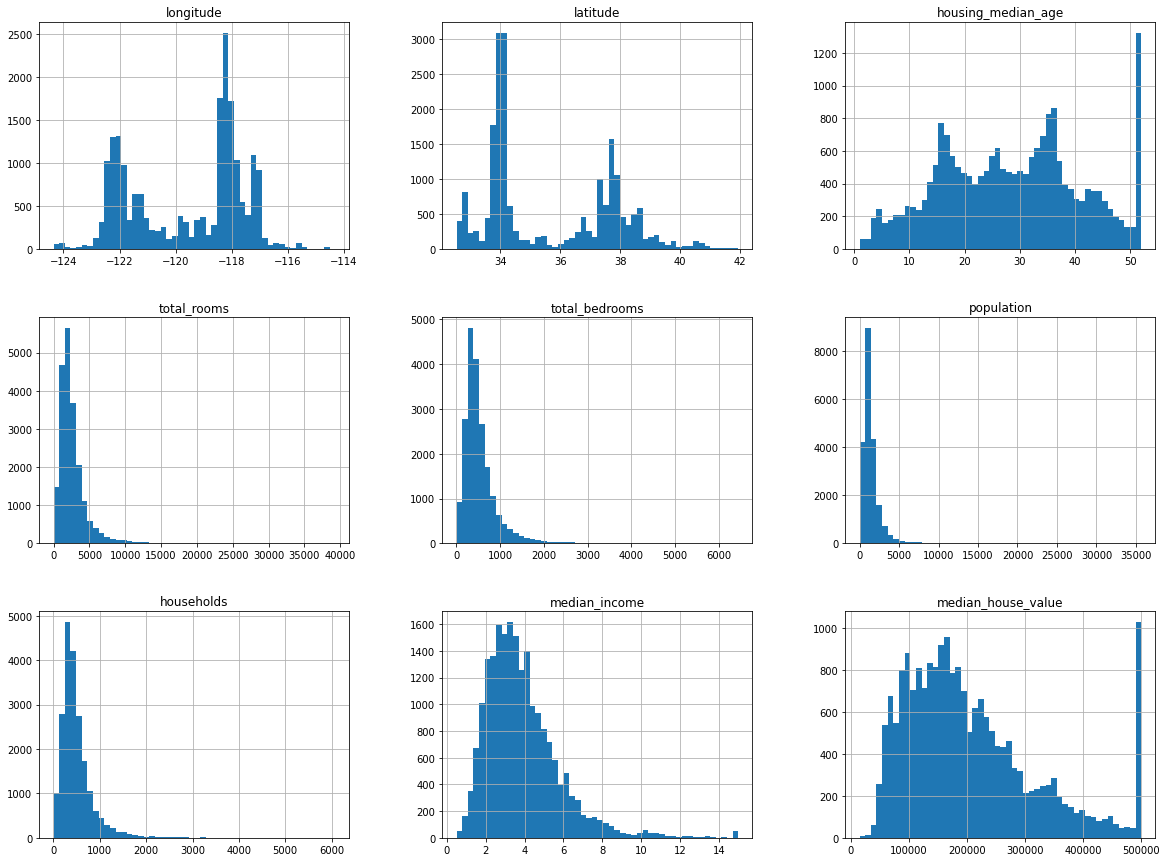

In [10]:
# data의 형태를 빠르게 검토하는 방법은 각 숫자형 특성을 histogram으로 그려보는 것
housing.hist(bins=50, figsize=(20, 15))

In [11]:
# 'median_income; 스케일을 조정하고 상한이 15, 하안이 0.5가 되도록 만들었음. 대략 3은 30,000 달러
# 'housing median age'와 'median house value' 역시 최댓값과 최솟값을 한정
# 'median house value'는 target label로 사용하기 때문에 심각한 문제가 될수 있음
# $500,000를 넘어가더라도 정확한 예측값이 필요하다고 한다면, 
# (1) 한계값 박의 구역에 대한 정확한 레이블을 구하거나
# (2) training set에서 $500,000 이 넘는 구역을 제거한다.
# histogram의 꼬리가 두껍다. (가운데에서 왼쪽보다 오른쪽이 더 멀리 뻗어 있다. 종모양의 분포가 되도록 변형시켜야 함)

### 2.3.4 테스트 세트 만들기
- 데이터를 더 깊게 들여다보기 전에 테스트 세트를 따로 떼어놓아야 한다. 그리고 테스트 세트를 절대 들어야보면 안된다.

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

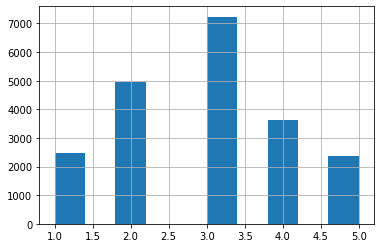

In [13]:
# very important
# 'median_income'이 매우 중요하다고 가정할때, 테스트 세트가 전체 데이터셋에 있는 여러 income 카테고리를 잘 대표해야 한다
# income에 대한 카테고리를 만들어야 한다. 
# 위의 histogram을 보면 대부분 1.5에서 6사이에 모여있고, 간혹 6이 넘기도 한다.
# 계층(category)별로 충분한 샘플수가 있어야 한다. 즉, 너무 많은 계층으로 나누면 안된다. 각 계층이 충분히 커야 한다.
# incom catogory 만들기

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 2, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [14]:
# 'income_cat'를 기반으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.239583
4    0.176357
1    0.118944
5    0.114583
Name: income_cat, dtype: float64

In [16]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

3    0.350594
2    0.239644
4    0.176296
1    0.119065
5    0.114402
Name: income_cat, dtype: float64

In [17]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.239632
4    0.176308
1    0.119041
5    0.114438
Name: income_cat, dtype: float64

In [18]:
# 'income_cat'를 삭제해서 데이터를 원래 상태로 되돌림

for set_ in(strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

## 2.4 데이터 이해를 위한 탐색과 시각화
- 먼저 테스트 세트를 때어놓았는지 확인하고 훈련 세트에 대해서만 탐색하기
- 데이터가 너무 크면 탐색을 위한 세트를 별도로 샘플링할수도 있다.

In [19]:
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화
- 지리정보 (위도와 경도)가 있으니 모든 구역을 산점도로 만들어 데이터를 시각화 한다.

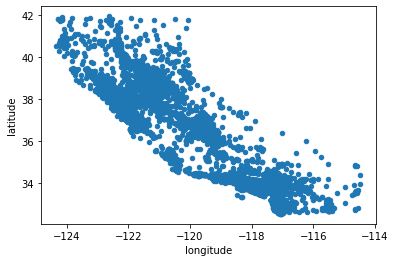

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude')

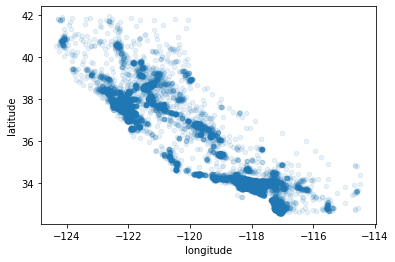

In [21]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

- 주택 가격
-- 원의 반지름: 구역의 인구(parameter s)
-- 색상: 가격 (parameter c)
-- colormap 중 'jet' 사용: 파란색에서 빨란색까지 범위를 가짐

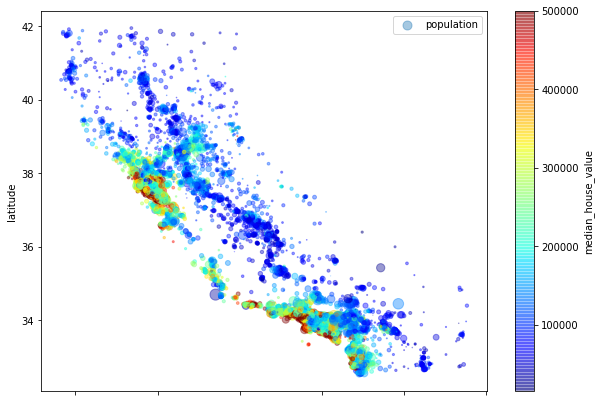

In [25]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10, 7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar='True')
plt.legend() 

- 위의 두 그래프를 비교하면 지역과 인구밀도와 관련이 매우 크다
- clustering algorithm을 사용해 주요 군집을 찾고 군집의 중심까지의 거리를 재는 feature를 추가

### 2.4.2 상관관계 조사
- daaset이 너무 크지 않으므로 모든 특성 간의 'standard correlation coefficient (Pearson의 r)를 corr() method를 이용해 계산

In [27]:
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688299
total_rooms           0.135022
housing_median_age    0.112630
households            0.064842
total_bedrooms        0.048717
population           -0.027142
longitude            -0.043234
latitude             -0.146107
Name: median_house_value, dtype: float64

- 위의 내용은 중간 주택 가겨과 다른 특성 상이의 상관관계 크기가 얼마나 되는지 알아본 것임
- 상관관계는 -1에서 1까지
- 1에 가까우면 강한 양의 상관관계, -1에 가까우면 강한 음의 상관관계
- latidude는 약한 음의 상관관계
- 0에 가까우면 상관관계가 없다

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f500ecd5a90>,
      dtype=object)

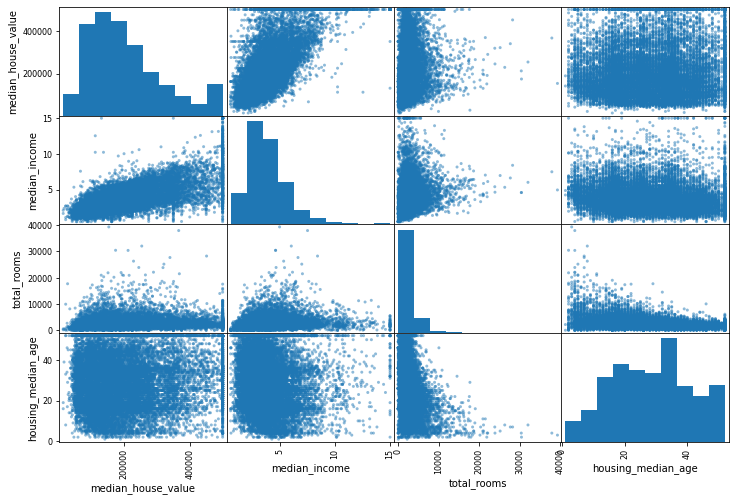

In [29]:
# 특성사이의 상관관계 확인하는 다른 방법 'scatter_matirx'

from pandas.plotting import scatter_matrix

attributes =['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))